In [1]:
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing import text
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding, LSTM, Bidirectional
from keras.layers import Conv1D, Flatten
#from keras.preprocessing import text
from keras.models import Sequential,Model
from keras.layers import Dense ,Activation,MaxPool1D,Conv1D,Flatten,Dropout,Activation,Dropout,Input,Lambda,concatenate
from tensorflow.keras.utils import to_categorical
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
import nltk
import csv
import pandas as pd

from tensorflow.keras.preprocessing import text as keras_text
from tensorflow.keras.preprocessing import sequence as keras_seq

In [3]:
data = pd.read_csv('/kaggle/input/qura-pr-qsn/train.csv')
pd.set_option('display.max_colwidth',80)
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) d...,0
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0


In [4]:
data.shape

(404290, 6)

In [5]:
print(data.dtypes)
print(data['question1'].dtypes)
print(data['question2'].dtypes)
type(data['question1'])

id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object
object
object


pandas.core.series.Series

# Setting target or labelfor each input

In [6]:
label_oneDimension=data['is_duplicate']

In [7]:
label_oneDimension.head(2)

0    0
1    0
Name: is_duplicate, dtype: int64

In [8]:
import numpy as np
label_twoDimension = to_categorical(data['is_duplicate'], num_classes=2)

In [9]:
label_twoDimension[0:1]

array([[1., 0.]])

In [10]:
question_one=data['question1'].astype(str)
print(question_one.head())

0              What is the step by step guide to invest in share market in india?
1                             What is the story of Kohinoor (Koh-i-Noor) Diamond?
2       How can I increase the speed of my internet connection while using a VPN?
3                              Why am I mentally very lonely? How can I solve it?
4    Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?
Name: question1, dtype: object


In [11]:
question_two=data['question2'].astype(str)
print(question_two.head())

0                          What is the step by step guide to invest in share market?
1    What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) d...
2                        How can Internet speed be increased by hacking through DNS?
3                  Find the remainder when [math]23^{24}[/math] is divided by 24,23?
4                                            Which fish would survive in salt water?
Name: question2, dtype: object


# Fitting text on a single tokenized object

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
tok_all = Tokenizer(char_level = False)
tok_all.fit_on_texts(question_one+question_two)

In [13]:
vocabulary_all=len(tok_all.word_counts)
print(vocabulary_all)

96494


# Train data Sequencing and Encoding

In [14]:
#Encoding question 1
encoded_q1=tok_all.texts_to_sequences(question_one)
print(question_one[0])
encoded_q1[0]

What is the step by step guide to invest in share market in india?


[2, 3, 1, 1221, 57, 1221, 2581, 7, 575, 8, 763, 383, 8, 35]

In [15]:
#Encoding question 2
encoded_q2=tok_all.texts_to_sequences(question_two)
print(question_two[0])
encoded_q2[0]

What is the step by step guide to invest in share market?


[2, 3, 1, 1221, 57, 1221, 2581, 7, 575, 8, 763, 383]

# Pre-Padding on Train data

In [16]:
#####Padding encoded sequence of words
from keras.preprocessing import sequence
max_length=100
padded_docs_q1 = sequence.pad_sequences(encoded_q1, maxlen=max_length, padding='pre')

In [17]:
#####Padding encoded sequence of words
from keras.preprocessing import sequence
max_length=100
padded_docs_q2 = sequence.pad_sequences(encoded_q2, maxlen=max_length, padding='pre')

# Reading Embedding Vector from Glove

In [18]:
import os
import numpy as np

In [19]:
embeddings_index = {}
f = open('/kaggle/input/glv-36/glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [20]:
#create embedding matrix

embedding_matrix = np.zeros((vocabulary_all+1, 300))
for word, i in tok_all.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		# words not found in embedding index will be all-zeros.
		embedding_matrix[i] = embedding_vector

# Defining Input Shape for Model

In [21]:
Question1_shape= Input(shape=[max_length])
Question1_shape.shape

(None, 100)

In [22]:
Question2_shape= Input(shape=[max_length])
Question2_shape.shape

(None, 100)

# Embedding Layer

In [23]:
Embedding_Layer = Embedding(vocabulary_all+1,300,weights=[embedding_matrix], input_length=max_length, trainable=False)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# CNN Network

In [24]:
CNN3_network=Sequential([Embedding_Layer,
                        Conv1D(32,3,activation="relu",padding='same'),
                       Dropout(0.2),
                       MaxPool1D(2),
                       Conv1D(64,5,activation="relu",padding='same'),
                       Dropout(0.2),
                       MaxPool1D(2),
                       Conv1D(64,5,activation="relu",padding='same'),
                       Dropout(0.2),
                       MaxPool1D(2),
                       Flatten(),
                       Dense(128,activation="linear"),
                       Dropout(0.3)
                       
                       ])

# Printing Model summary

In [25]:
CNN3_network.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │      28,948,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,948,500 (110.43 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 28,948,500 (110.43 MB)

# create siamese network from CNN model and store output feature vectors

In [27]:
Question1_CNN_feature=CNN3_network(Question1_shape)
Question2_CNN_feature=CNN3_network(Question2_shape)

# Adding and multiplying features obtained from Siamese CNN network

In [28]:
from keras import backend as K
from keras.optimizers import Adam

In [29]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Bidirectional

# Assuming you've already defined and compiled your Bi-LSTM model
# Example: Simple Bi-LSTM Model
input1 = Input(shape=(100, 128))  # Example input shape: (sequence_length, feature_size)
input2 = Input(shape=(100, 128))

# Example Bi-LSTM Layer
bi_lstm = Bidirectional(LSTM(64))(input1)

# Getting features from your Bi-LSTM model
Question1_Bi_lstm_feature = bi_lstm  # Replace with actual output of your model
Question2_Bi_lstm_feature = bi_lstm  # Replace with actual output of your model

# Define the Lambda for Absolute Difference
lamda_function = Lambda(lambda tensor: K.abs(tensor[0] - tensor[1]), 
                        name="Absolute_distance", 
                        output_shape=lambda input_shapes: input_shapes[0])  # output shape same as input shape

# Apply Lambda layer for absolute difference
abs_distance_vector = lamda_function([Question1_Bi_lstm_feature, Question2_Bi_lstm_feature])

# Define the Lambda for Hadamard Product (element-wise multiplication)
lamda_function2 = Lambda(lambda tensor: K.abs(tensor[0] * tensor[1]), 
                         name="Hadamard_multiplication", 
                         output_shape=lambda input_shapes: input_shapes[0])  # output shape same as input shape

# Apply Lambda layer for Hadamard product
hamadard_vector = lamda_function2([Question1_Bi_lstm_feature, Question2_Bi_lstm_feature])


# Adding abs_distance_vector and hamadard_vector

In [30]:
from keras.layers import Add

In [31]:
added_vecotr = Add()([abs_distance_vector, hamadard_vector])

# Final Model prediction

In [36]:
predict=Dense(2,activation="sigmoid")(added_vecotr)

# Creating sequential model using Model() class and compilation

In [39]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# Assuming Question1_shape and Question2_shape are defined
Siamese3_Network = Model(inputs=[Question1_shape, Question2_shape], outputs=predict)

# Use 'learning_rate' instead of 'lr'
Siamese3_Network.compile(loss="binary_crossentropy", 
                         optimizer=Adam(learning_rate=0.00003),  # Correct argument name
                         metrics=["accuracy"])


In [40]:
Siamese3_Network.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 100, 128)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 128)            │         98,816 │ input_layer_3[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Absolute_distance         │ (None, 128)            │              0 │ bidirectional[0][0],   │
│ (Lambda)                  │                        │                │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Hadamard_multiplication   │ (None, 128)            │              0 │ bidirectional[0][0],   │
│ (Lambda)                  │                        │                │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 128)            │              0 │ Absolute_distance[0][… │
│                           │                        │                │ Hadamard_multiplicati… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer (InputLayer)  │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2)              │            258 │ add[0][0]              │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 99,074 (387.01 KB)

 Trainable params: 99,074 (387.01 KB)

 Non-trainable params: 0 (0.00 B)

# Setting hyperparameter for training

In [42]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
earlystopper = EarlyStopping(patience=8, verbose=1)
#checkpointer = ModelCheckpoint(filepath = 'cnn_model_one_.{epoch:02d}-{val_loss:.6f}.hdf5',
 #                              verbose=1,
 #                              save_best_only=True, save_weights_only = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9,
                              patience=2, min_lr=0.00001, verbose=1)

# Data split into train and validation set

# Model fitting or training


In [46]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, Lambda
import tensorflow as tf
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Assuming padded_docs_q1, padded_docs_q2, label_twoDimension are already defined
q1_train, q1_val, q2_train, q2_val, label_train, label_val = train_test_split(
    padded_docs_q1, padded_docs_q2, label_twoDimension, test_size=0.30, random_state=42
)

# Check shapes
print(f"q1_train shape: {q1_train.shape}")  # Should be (num_samples, sequence_length)
print(f"q2_train shape: {q2_train.shape}")  # Should be (num_samples, sequence_length)
print(f"label_train shape: {label_train.shape}")  # Should be (num_samples, 2)
print(f"q1_val shape: {q1_val.shape}")  # Should be (num_samples, sequence_length)
print(f"q2_val shape: {q2_val.shape}")  # Should be (num_samples, sequence_length)
print(f"label_val shape: {label_val.shape}")  # Should be (num_samples, 2)

# Define the Siamese Network
def build_siamese_network(input_shape, vocab_size, embedding_dim):
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
    
    # Embedding layer to convert integer sequences to dense vectors
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_shape[0])
    
    embedded_a = embedding_layer(input_a)
    embedded_b = embedding_layer(input_b)
    
    # Shared LSTM layer
    shared_lstm = LSTM(64)
    
    encoded_a = shared_lstm(embedded_a)
    encoded_b = shared_lstm(embedded_b)
    
    # Distance layer using Lambda
    def absolute_difference(tensors):
        return tf.abs(tensors[0] - tensors[1])
    
    distance = Lambda(absolute_difference, output_shape=(64,))([encoded_a, encoded_b])
    
    # Output layer for one-hot encoded labels (2 units with softmax)
    output = Dense(2, activation='softmax')(distance)
    
    model = Model(inputs=[input_a, input_b], outputs=output)
    return model

# Define parameters
vocab_size = 10000  # Adjust based on your vocabulary size
embedding_dim = 100  # Adjust based on your embedding dimension
input_shape = (q1_train.shape[1],)  # Sequence length

# Build the model
Siamese3_Network = build_siamese_network(input_shape, vocab_size, embedding_dim)
Siamese3_Network.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)

# Fit the model
history = Siamese3_Network.fit(
    [q1_train, q2_train], label_train,
    batch_size=256, epochs=100,
    validation_data=([q1_val, q2_val], label_val),
    callbacks=[earlystopper, reduce_lr]
)

# Save the model
Siamese3_Network.save('siamese3_model.h5')

q1_train shape: (283003, 100)
q2_train shape: (283003, 100)
label_train shape: (283003, 2)
q1_val shape: (121287, 100)
q2_val shape: (121287, 100)
label_val shape: (121287, 2)
Epoch 1/100
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.6764 - loss: 0.5783 - val_accuracy: 0.7777 - val_loss: 0.4669 - learning_rate: 0.0010
Epoch 2/100
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.7992 - loss: 0.4273 - val_accuracy: 0.7984 - val_loss: 0.4331 - learning_rate: 0.0010
Epoch 3/100
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.8346 - loss: 0.3628 - val_accuracy: 0.8027 - val_loss: 0.4230 - learning_rate: 0.0010
Epoch 4/100
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.8602 - loss: 0.3148 - val_accuracy: 0.8093 - val_loss: 0.4203 - learning_rate: 0.0010
Epoch 5/100
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.8818 - loss: 0.2737 - val_accuracy: 0.8117 - val_loss: 0.4377 - learning_rate: 0.0010
Epoch 6/100
1106/1106 ━━━━━━━━━━━━━━━━━

# Model Prediction

In [47]:
Siamese3_Network_predictions = Siamese3_Network.predict([q1_val,q2_val])
#Siamese3_Network_predictions = Siamese3_Network.predict([padded_docs_q1_test,padded_docs_q2_test])
Siamese3_Network_predictions

3791/3791 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step


array([[8.4325480e-01, 1.5674520e-01],
       [9.9999893e-01, 1.1123465e-06],
       [9.9995184e-01, 4.8136924e-05],
       ...,
       [8.9723826e-06, 9.9999106e-01],
       [8.0125731e-01, 1.9874264e-01],
       [9.9693489e-01, 3.0650627e-03]], dtype=float32)

In [ ]:
#Siamese3_Network_predictions_testData = Siamese3_Network.predict([padded_docs_q1_test,padded_docs_q1_test])

# Log loss

In [48]:
from sklearn.metrics import log_loss
log_loss_val= log_loss(label_val,Siamese3_Network_predictions)
log_loss_val

0.6425034818191955

# Classification report

In [49]:
predictions = np.zeros_like(Siamese3_Network_predictions)
predictions[np.arange(len(Siamese3_Network_predictions)), Siamese3_Network_predictions.argmax(1)] = 1

In [50]:
predictionInteger=(np.argmax(predictions, axis=1))
#print('np.argmax(a, axis=1): {0}'.format(np.argmax(predictions, axis=1)))
predictionInteger

array([0, 0, 0, ..., 1, 0, 0])

In [51]:
from sklearn.metrics import classification_report
print(classification_report(label_val,predictions))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84     76350
           1       0.73      0.76      0.74     44937

   micro avg       0.81      0.81      0.81    121287
   macro avg       0.79      0.80      0.79    121287
weighted avg       0.81      0.81      0.81    121287
 samples avg       0.81      0.81      0.81    121287



In [52]:
from sklearn.metrics import precision_recall_fscore_support
print ("Precision, Recall, F1_score : macro ",precision_recall_fscore_support(label_oneD_val,predictionInteger, average='macro'))
print ("Precision, Recall, F1_score : micro ",precision_recall_fscore_support(label_oneD_val,predictionInteger, average='micro'))
print ("Precision, Recall, F1_score : weighted ",precision_recall_fscore_support(label_oneD_val,predictionInteger, average='weighted'))

Precision, Recall, F1_score : macro  (0.7924003985210823, 0.7965665151032445, 0.7943137753837461, None)
Precision, Recall, F1_score : micro  (0.8067064071170035, 0.8067064071170035, 0.8067064071170035, None)
Precision, Recall, F1_score : weighted  (0.8083766027239929, 0.8067064071170035, 0.8073899146009983, None)


# Final train and val loss

In [53]:
min_val_loss = min(history.history["val_loss"])
min_train_loss = min(history.history["loss"])
max_val_acc = max(history.history["val_accuracy"])
max_train_acc = max(history.history["accuracy"])
print("min_train_loss=%g, min_val_loss=%g, max_train_acc=%g, max_val_acc=%g" % (min_train_loss,min_val_loss,max_train_acc,max_val_acc))

min_train_loss=0.100174, min_val_loss=0.420349, max_train_acc=0.963605, max_val_acc=0.811695


# Plot epoch Vs loss

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

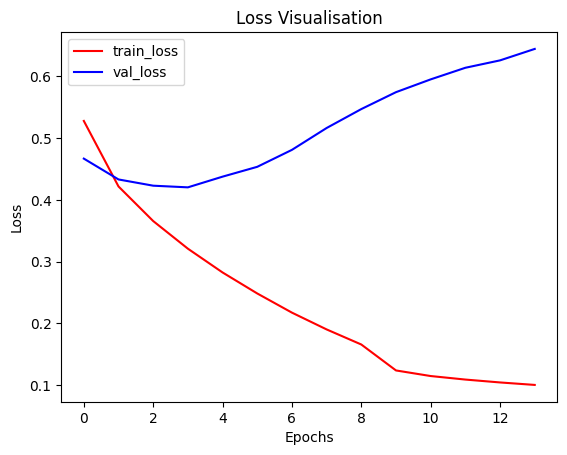

In [54]:
from matplotlib import pyplot as plt
plt.plot(history.history["loss"],color = 'red', label = 'train_loss')
plt.plot(history.history["val_loss"],color = 'blue', label = 'val_loss')
plt.title('Loss Visualisation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('3Layer_CNN_lossPlot_siamese.pdf',dpi=1000)

from google.colab import files
files.download('3Layer_CNN_lossPlot_siamese.pdf') 

# Plot Epoch Vs Accuracy

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

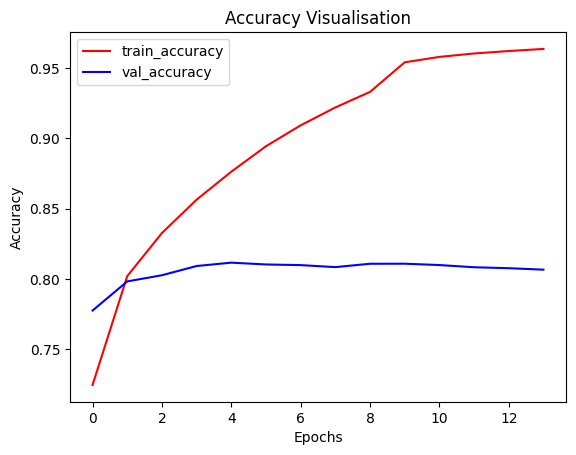

In [55]:
plt.plot(history.history["accuracy"],color = 'red', label = 'train_accuracy')
plt.plot(history.history["val_accuracy"],color = 'blue', label = 'val_accuracy')
plt.title('Accuracy Visualisation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('3Layer_CNN_accuracyPlot_siamese.pdf',dpi=1000)
files.download('3Layer_CNN_accuracyPlot_siamese.pdf') 

# Area Under Curve- ROC

In [56]:
#pred_test = Siamese3_Network.predict([padded_docs_q1_test,padded_docs_q2_test])
pred_train = Siamese3_Network.predict([q1_train,q2_train])
pred_val = Siamese3_Network.predict([q1_val,q2_val])

8844/8844 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step
3791/3791 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

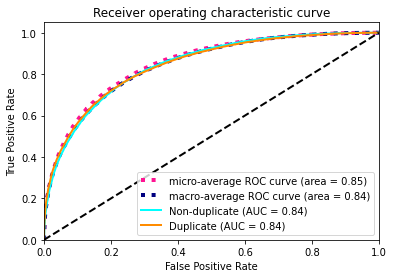

In [ ]:
plot_AUC_ROC(label_val,pred_val)